# CryptoNet implementation and training on MNIST dataset

In [85]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import save_image
import torch.optim as optim
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from torch.utils.tensorboard import SummaryWriter
import math

Model

In [ ]:
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    #plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.1, top=0.1) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    #print(layers)
    #print(ave_grads)

In [ ]:
## DUMMY MODEL
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()        
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)    
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output  # return x for visualization

In [104]:
class ScaledAvgPool2d(nn.Module):
    def __init__(self,kernel_size):
      super().__init__()
      self.kernel_size = kernel_size
      self.AvgPool = nn.AvgPool2d(kernel_size=self.kernel_size, stride=1, padding=1)
    
    def forward(self,x):
      return (self.kernel_size**2)*self.AvgPool(x)

class CryptoNet(nn.Module):
  '''
    TO DO: check how in the paper the avg pool does not downscale the input size...weird padding?
  '''
  def __init__(self):
    super().__init__()
    self.pad = F.pad
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=5, stride=2)
    self.square1 = torch.square
    self.scaledAvgPool1 = ScaledAvgPool2d(kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=5, out_channels=50, kernel_size=5, stride=2)
    self.scaledAvgPool2 = ScaledAvgPool2d(kernel_size=3)
    self.fc1 = nn.Linear(in_features=1250, out_features=100) # in paper in_features was 1250
    self.square2 = torch.square
    self.fc2 = nn.Linear(in_features=100, out_features=10)
    self.sigmoid = torch.sigmoid
    self.ReLU = torch.nn.ReLU() # testing on vanishing

  def forward(self, x):
    x = self.pad(x, (1,0,1,0))
    x = self.conv1(x)
    x = self.square1(x)
    x = self.scaledAvgPool1(x)
    x = self.conv2(x)
    x = self.scaledAvgPool2(x)
    ## Flatten
    x = x.reshape(x.shape[0], -1)
    x = self.fc1(x)
    x = self.square2(x)
    x = self.fc2(x)
    x = self.sigmoid(x)
    
    return x

  def weights_init(self):
    for l in self.children():
      if isinstance(l, nn.Conv2d):
        n = l.in_channels
        for k in l.kernel_size:
          n *= k
        stdv = 1. / math.sqrt(n)
        l.weight.data.uniform_(-stdv, stdv)
        if l.bias is not None:
          l.bias.data.uniform_(-stdv, stdv)

      elif isinstance(l, nn.Linear):
        stdv = 1. / math.sqrt(l.weight.size(1))
        l.weight.data.uniform_(-stdv, stdv)
        if l.bias is not None:
          l.bias.data.uniform_(-stdv, stdv)


Load Datasets

In [ ]:

class DataHandler():
  def __init__(self, dataset : str):
    if dataset == "MNIST":
      transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
      train_ds = MNIST("data/", train=True, download=True, transform=transform)
      test_ds = MNIST("data/", train=False, download=True)

      self.train_dl = DataLoader(train_ds, batch_size = 256, shuffle=True, drop_last=True)
      self.test_dl = DataLoader(test_ds, batch_size = 256, shuffle=True, drop_last=True)



Training

Epoch [1/1], Step [100/468], Loss: 2.4027
Epoch [1/1], Step [200/468], Loss: 2.4105
Epoch [1/1], Step [300/468], Loss: 2.3949
Epoch [1/1], Step [400/468], Loss: 2.3402


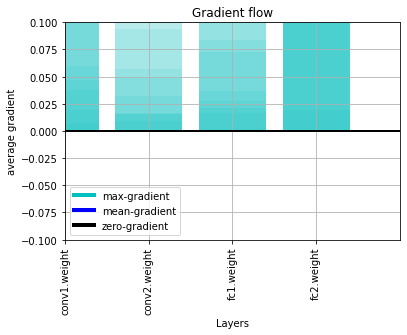

In [105]:
torch.manual_seed(42)
torch.autograd.set_detect_anomaly(True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CryptoNet()
model.weights_init()
#model = CNN()

def grad_clipping(model):
  for p in model.parameters():
    p.register_hook(lambda grad: print(grad))
    p.register_hook(lambda grad: torch.clamp(grad, 0, 1.0))

    p.register_hook(lambda grad: print(f"{p} -> {grad}"))


#grad_clipping(model)
model = model.to(device=device)
dataHandler = DataHandler("MNIST")

learning_rate = 0.001
momentum = 0.9
num_epochs = 1
total_step = len(dataHandler.train_dl)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.train()
for epoch in range(num_epochs):
  for i, (data, labels) in enumerate(dataHandler.train_dl):
    data = data.to(device=device)
    labels = labels.to(device=device)
    #labels = labels.to(torch.float32)

    ## Forward
    optimizer.zero_grad()
    predictions = model(data)
    loss = criterion(predictions, labels)
    loss.backward()
    plot_grad_flow(model.named_parameters())
    optimizer.step()

    if (i+1) % 100 == 0:
      print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
torch.save(model, "cryptoNet.pt")

Testing

['conv1.0.weight', 'conv2.0.weight', 'out.weight']
[tensor(0.0055), tensor(0.0038), tensor(0.0065)]
['conv1.0.weight', 'conv2.0.weight', 'out.weight']
[tensor(0.0054), tensor(0.0037), tensor(0.0060)]
['conv1.0.weight', 'conv2.0.weight', 'out.weight']
[tensor(0.0063), tensor(0.0039), tensor(0.0060)]
['conv1.0.weight', 'conv2.0.weight', 'out.weight']
[tensor(0.0080), tensor(0.0043), tensor(0.0066)]
['conv1.0.weight', 'conv2.0.weight', 'out.weight']
[tensor(0.0090), tensor(0.0047), tensor(0.0065)]
['conv1.0.weight', 'conv2.0.weight', 'out.weight']
[tensor(0.0138), tensor(0.0054), tensor(0.0082)]
['conv1.0.weight', 'conv2.0.weight', 'out.weight']
[tensor(0.0172), tensor(0.0060), tensor(0.0076)]
['conv1.0.weight', 'conv2.0.weight', 'out.weight']
[tensor(0.0229), tensor(0.0062), tensor(0.0079)]
['conv1.0.weight', 'conv2.0.weight', 'out.weight']
[tensor(0.0239), tensor(0.0062), tensor(0.0082)]
['conv1.0.weight', 'conv2.0.weight', 'out.weight']
[tensor(0.0258), tensor(0.0066), tensor(0.0108)]


KeyboardInterrupt: ignored

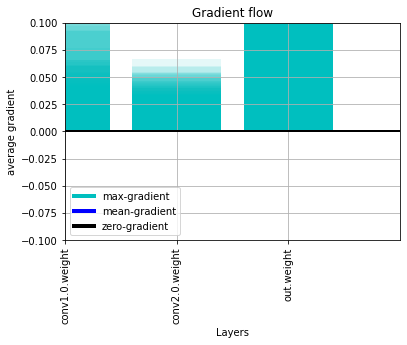

In [ ]:
torch.manual_seed(42)
torch.autograd.set_detect_anomaly(True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN()

def grad_clipping(model):
  for p in model.parameters():
    p.register_hook(lambda grad: print(grad))
    p.register_hook(lambda grad: torch.clamp(grad, 0, 1.0))

    p.register_hook(lambda grad: print(f"{p} -> {grad}"))

#grad_clipping(model)
model = model.to(device=device)
dataHandler = DataHandler("MNIST")

learning_rate = 0.001
momentum = 0.9
num_epochs = 1
total_step = len(dataHandler.train_dl)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.train()
for epoch in range(num_epochs):
  for i, (data, labels) in enumerate(dataHandler.train_dl):
    data = data.to(device=device)
    labels = labels.to(device=device)
    #labels = labels.to(torch.float32)

    ## Forward
    optimizer.zero_grad()
    predictions = model(data)
    loss = criterion(predictions, labels)
    loss.backward()
    plot_grad_flow(model.named_parameters())
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    if (i+1) % 100 == 0:
      print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
torch.save(model, "cryptoNet.pt")